In [1]:
import ctypes
from ctypes.util import find_library

def unload_lib(lib):
    """Unload the loaded CDLL library from memory."""
    if not hasattr(lib, "_handle"):
        raise ValueError("Object is not a loaded CDLL library.")
    
    # Ищем libdl
    libdl_path = find_library("dl")
    if not libdl_path:
        raise RuntimeError("libdl not found — unloading .so is not possible.")
    
    libdl = ctypes.CDLL(libdl_path)

    dlclose = libdl.dlclose
    dlclose.argtypes = [ctypes.c_void_p]
    dlclose.restype = ctypes.c_int

    handle = lib._handle
    ret = dlclose(handle)

    if ret == 0:
        print(f"✅ Library {lib._name} unloaded from memory.")
        return True
    else:
        # you can call ctypes.get_errno(), but dlclose does not set errno on all systems
        print(f"❌ dlclose returned code {ret}. Library may not be unloaded.")
        return False

In [2]:
# after loading:
#lib = ctypes.CDLL("./mendrive_det.so")

# ... work ...

# before recompilation:
if 'lib' in locals():
    unload_lib(lib)
    del lib
    import gc; gc.collect()

# we recompile
#!gcc -shared -fPIC -O3 -o mendrive_det.so mendrive_det.c -lm

# we load again
#lib = ctypes.CDLL("./mendrive_det.so")

In [3]:
def compile_lib(name):
    import os 
    # Command to execute -lgsl -lgslcblas -lm
    # cmd = "gcc -shared -fPIC -O3 -o {name}.so {name}.c -lm".format(name=name)
    
    cmd = """gcc -shared -fPIC -O3 -o {name}.so \
        {name}.c \
        -DINCLUDE_CUBA_H \
        -I./local/include \
        -L./local/lib \
        -Wl,-rpath='\\$ORIGIN/local/lib' \
        -lcuba -lm
    """.format(name=name)

    # Using os.system() method
    os.system(cmd)

In [4]:
compile_lib("calc_longitudinal_sphere_mass")

In [5]:
def load_and_init_lib(name):
    import ctypes
    from ctypes import Structure, c_double, c_int, c_longdouble, POINTER, CDLL, byref

    # Loading the library
    lib = CDLL("./{name}.so".format(name=name))

    # Function binding
    lib.integrate.argtypes = [
        c_double, # R0,       /* Радиус сферы */
        c_double, # v0,       /* Начальная продольная скорость */
        c_double, # a,        /* Продольное ускорение */
        c_double, # c,        /* Скорость света */
        c_double, # t,        /* Текущее время */
        c_double, # t0,       /* Начальное время */
        c_int,    # use_delay,
        c_int,    # use_lorentz_factor,
        c_int,    # use_lorentz_general_factor,
        c_int,    # use_fermi_factor_O,
        c_int,    # use_fermi_factor,
        c_int,    # use_fermi_general_factor,
        c_int,    # use_fast_integrand,
        POINTER(c_double), # cubareal* integral
        POINTER(c_double), # cubareal* error
        POINTER(c_double), # cubareal* prob)
    ]
    lib.integrate.restype  = c_int

   
    return lib

# Function call:
def c_integrate(lib,
                R0,       # /* Радиус сферы */
                v0,       # /* Начальная продольная скорость */
                a,        # /* Продольное ускорение */
                c,        # /* Скорость света */
                t,        # /* Текущее время */
                t0,       # /* Начальное время */
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand):

    import ctypes
    from ctypes import c_int,  c_double,  POINTER, byref
    import numpy as np

    NCOMP = 9
    integ = np.zeros(NCOMP, dtype=np.float64)
    error = np.zeros(NCOMP, dtype=np.float64)
    prob  = np.zeros(NCOMP, dtype=np.float64)

    lib.integrate(c_double(R0),
                  c_double(v0),
                  c_double(a),
                  c_double(c),
                  c_double(t),
                  c_double(t0),
                  c_int(use_delay),
                  c_int(use_lorentz_factor),
                  c_int(use_lorentz_general_factor),
                  c_int(use_fermi_factor_O),
                  c_int(use_fermi_factor),
                  c_int(use_fermi_general_factor),
                  c_int(use_fast_integrand),
                  integ.ctypes.data_as(POINTER(c_double)),
                  error.ctypes.data_as(POINTER(c_double)),
                  prob.ctypes.data_as(POINTER(c_double))
    )
    
    result_names = [
        "observed_ratio_1_x ",
        "observed_ratio_1_y ",
        "observed_ratio_1_z ",
        "observed_ratio_2_x ",
        "observed_ratio_2_y ",
        "observed_ratio_2_z ",
        "observed_ratio_x   ",
        "observed_ratio_y   ",
        "observed_ratio_z   "];
    for comp in range(0, 9):
        print(result_names[comp], integ[comp], error[comp], prob[comp])
        
    return integ, error, prob

In [6]:
lib = load_and_init_lib("calc_longitudinal_sphere_mass")

In [7]:
def calc_longitudinal_sphere_mass(a,
                                  use_delay,
                                  use_lorentz_factor,
                                  use_fermi_factor):
    R0  = 1;      # /* радиус сферы (половина R1) */
    v0  = 0
    c   = 1;      # /* скорость света в м/с */
    v_c = v0 / c; # /* отношение скорости заряда к скорости света*/
    t   = 0
    t0  = 0

    # use_delay                  = 1;
    # use_lorentz_factor         = 1;
    use_lorentz_general_factor = 0;
    use_fermi_factor_O         = 0;
    # use_fermi_factor           = 0;
    use_fermi_general_factor   = 0;
    use_fast_integrand         = 1;

    integ, error, prob = c_integrate(lib,
                R0,  #   /* Радиус сферы */
                v0,  #   /* Радиус орбиты */
                a,   #   /* Угловая скорость */
                c,   #   /* Скорость света */
                t,
                t0,
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand)
    return integ[2], integ[5], integ[8], v_c.n()

In [8]:
mass_array                  = []
mass_fermi_array            = []
mass_hysteresis_array       = []
mass_hysteresis_lw_array    = []
mass_hysteresis_fermi_array = []

In [9]:
def append_mass_hysteresis(va):
    global mass_array
    global mass_fermi_array
    global mass_hysteresis_array
    global mass_hysteresis_lw_array
    global mass_hysteresis_fermi_array

    for a in va:
        observed_ratio_1_z, observed_ratio_2_z, observed_ratio_z, v_c \
            = calc_longitudinal_sphere_mass(a = a, \
                                          use_delay = 1, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 0)
        m1 = observed_ratio_1_z
        m2 = observed_ratio_2_z
        m = observed_ratio_z
        observed_ratio_1_z, observed_ratio_2_z, observed_ratio_z, v_c \
            = calc_longitudinal_sphere_mass(a = a, 
                                          use_delay = 1, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 1)
        m1_f = observed_ratio_1_z
        m2_f = observed_ratio_2_z
        m_f = observed_ratio_z

        mass_array += [(a, m1, m2)]
        mass_fermi_array += [(a, m1_f, m2_f)]
        mass_hysteresis_array += [(a, m, m_f)]
        mass_hysteresis_lw_array += [(a, m)]
        mass_hysteresis_fermi_array += [(a, m_f)]

In [10]:
use_lorentz_factor = 0

In [ ]:
append_mass_hysteresis([0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25, 0.26])

In [12]:
use_lorentz_factor = 1

In [ ]:
append_mass_hysteresis([0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25, 0.26])

In [14]:
mass_hysteresis_lw_array

[(0.0500000000000000, -1.337538824980675),
 (0.0600000000000000, -1.3397989827994068),
 (0.0700000000000000, -1.3421337345370594),
 (0.0800000000000000, -1.34501607573583),
 (0.0900000000000000, -1.3482351200989149),
 (0.100000000000000, -1.3511924356987641),
 (0.110000000000000, -1.3550556616704805),
 (0.120000000000000, -1.359549207266726),
 (0.130000000000000, -1.3639767311340716),
 (0.140000000000000, -1.368803587593544),
 (0.150000000000000, -1.374568044112766),
 (0.200000000000000, -1.4128932160523366),
 (0.250000000000000, -1.4731075025496205),
 (0.260000000000000, nan),
 (0.0500000000000000, -1.3379546790585364),
 (0.0600000000000000, -1.34034718242408),
 (0.0700000000000000, -1.3429432587102201),
 (0.0800000000000000, -1.346071023529814),
 (0.0900000000000000, -1.3495555737744795),
 (0.100000000000000, -1.3529235265498338),
 (0.110000000000000, -1.357318281472198),
 (0.120000000000000, -1.3620117512234775),
 (0.130000000000000, -1.3669442758963108),
 (0.140000000000000, -1.372

In [15]:
# было с ошибкой в знаке перед индуктивной массой
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = 1.2
_electrostatic_energy = 1.2
(0.4+1.2)/1.2

1.33333333333333

In [16]:
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = -1.2
_electrostatic_energy = 0.6 # W = 3 e^2 / (5 a)
(0.4-1.2)/0.6

-1.33333333333333

In [17]:
mass_array

[(0.0500000000000000, 0.6749060492481582, -2.011185486996094),
 (0.0600000000000000, 0.6783732796560448, -2.016167049418277),
 (0.0700000000000000, 0.6825491204710902, -2.021873004531069),
 (0.0800000000000000, 0.6875806196942416, -2.0289080252725564),
 (0.0900000000000000, 0.693509897348115, -2.0369592903691873),
 (0.100000000000000, 0.700440480402901, -2.0456015511678047),
 (0.110000000000000, 0.7078041248863164, -2.0553993746917527),
 (0.120000000000000, 0.7161652185767604, -2.066750341376839),
 (0.130000000000000, 0.7255730703712328, -2.0788631357795),
 (0.140000000000000, 0.7361720368106398, -2.0924031844445703),
 (0.150000000000000, 0.7480886009316389, -2.108005362793514),
 (0.200000000000000, 0.8328349689617822, -2.215846159248414),
 (0.250000000000000, 1.0061719032889338, -2.419937964299301),
 (0.260000000000000, nan, nan),
 (0.0500000000000000, 0.6748291982295324, -2.01153133788493),
 (0.0600000000000000, 0.6782230805929739, -2.0165673017082266),
 (0.0700000000000000, 0.682368

In [18]:
mass_fermi_array

[(0.0500000000000000, 1.0077367753831235, -2.008780856758443),
 (0.0600000000000000, 1.0107071849757787, -2.0130355519340655),
 (0.0700000000000000, 1.0145758356104795, -2.0174284039359263),
 (0.0800000000000000, 1.019090118646172, -2.0228236306326135),
 (0.0900000000000000, 1.0243999845062028, -2.029167422045028),
 (0.100000000000000, 1.030542983842597, -2.036369534451126),
 (0.110000000000000, 1.0378769966393984, -2.0446118243199316),
 (0.120000000000000, 1.0454732620611902, -2.053016478112124),
 (0.130000000000000, 1.0534099969595827, -2.062709531906442),
 (0.140000000000000, 1.063108810052314, -2.0738366749051065),
 (0.150000000000000, 1.0735622357308148, -2.0854178750383485),
 (0.200000000000000, 1.1471518378206478, -2.1683761486684303),
 (0.250000000000000, 1.29028097221131, -2.318926063651775),
 (0.260000000000000, nan, nan),
 (0.0500000000000000, 1.0076337747653403, -2.0091576989720465),
 (0.0600000000000000, 1.0105733872655231, -2.0135247735425943),
 (0.0700000000000000, 1.014

In [19]:
mass_hysteresis_array

[(0.0500000000000000, -1.337538824980675, -1.0021937823085578),
 (0.0600000000000000, -1.3397989827994068, -1.0039233650661785),
 (0.0700000000000000, -1.3421337345370594, -1.0056183664360274),
 (0.0800000000000000, -1.34501607573583, -1.0074759913710882),
 (0.0900000000000000, -1.3482351200989149, -1.0095254393436393),
 (0.100000000000000, -1.3511924356987641, -1.0117747388557057),
 (0.110000000000000, -1.3550556616704805, -1.0140391998285512),
 (0.120000000000000, -1.359549207266726, -1.0165850679869823),
 (0.130000000000000, -1.3639767311340716, -1.0197242378095586),
 (0.140000000000000, -1.368803587593544, -1.0233096765203775),
 (0.150000000000000, -1.374568044112766, -1.0266201032246356),
 (0.200000000000000, -1.4128932160523366, -1.0510453424625927),
 (0.250000000000000, -1.4731075025496205, -1.088102259362863),
 (0.260000000000000, nan, nan),
 (0.0500000000000000, -1.3379546790585364, -1.0026627131944021),
 (0.0600000000000000, -1.34034718242408, -1.0045983993735361),
 (0.070000

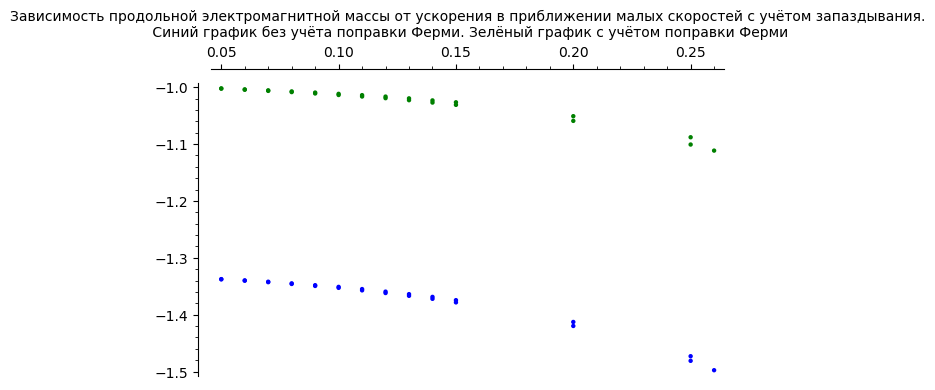

In [20]:
(list_plot(mass_hysteresis_lw_array) + list_plot(mass_hysteresis_fermi_array, color="green")
) .show(title = 
        "Зависимость продольной электромагнитной массы от ускорения"
        " в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график без учёта поправки Ферми. Зелёный график с учётом поправки Ферми")

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженного сферического слоя с общим зарадом $e$ и радиусом $r$ равна $\frac{2}{3} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{1}{2} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженной сферы с общим зарадом $e$ и радиусом $r$ равна $\frac{8}{5} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{6}{5} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.